# 1. Loading

In [1]:
import tensorflow as tf
LIMIT = 2

gpus = tf.config.experimental.list_physical_devices('GPU:3')
if gpus:
  try:
    tf.config.experimental.set_virtual_device_configuration(
        gpus[0],
        [tf.config.experimental.VirtualDeviceConfiguration(memory_limit = 1024 * LIMIT)])
    logical_gpus = tf.config.experimental.list_logical_devices('GPU')
    print('We will restrict TensorFlow to max %iGB GPU RAM'%LIMIT)
    print('then RAPIDS can use %iGB GPU RAM'%(16 - LIMIT))
  except RuntimeError as e:
    print(e)
else:
    print("GPU is not running")

GPU is not running


In [2]:
import numpy as np
import pandas as pd
df = pd.read_csv("../input/shopee-product-matching/train.csv")
print(df.shape)
df.head()

(34250, 5)


,posting_id,image,image_phash,title,label_group
0,train_129225211,0000a68812bc7e98c42888dfb1c07da0.jpg,94974f937d4c2433,Paper Bag Victoria Secret,249114794
1,train_3386243561,00039780dfc94d01db8676fe789ecd05.jpg,af3f9460c2838f0f,"Double Tape 3M VHB 12 mm x 4,5 m ORIGINAL / DO...",2937985045
2,train_2288590299,000a190fdd715a2a36faed16e2c65df7.jpg,b94cb00ed3e50f78,Maling TTS Canned Pork Luncheon Meat 397 gr,2395904891
3,train_2406599165,00117e4fc239b1b641ff08340b429633.jpg,8514fc58eafea283,Daster Batik Lengan pendek - Motif Acak / Camp...,4093212188
4,train_3369186413,00136d1cf4edede0203f32f05f660588.jpg,a6f319f924ad708c,Nescafe \xc3\x89clair Latte 220ml,3648931069


In [3]:
DEBUG = False
if DEBUG:
    df = df.sample(n = 2000).reset_index(drop = True)
print(df.shape)

(34250, 5)


In [4]:
from sklearn.model_selection import GroupKFold
groups = df["label_group"].values
gkf = GroupKFold(n_splits = 5)
for train_idx, valid_idx in gkf.split(df, groups, groups):
    train = df.iloc[train_idx, :].copy()
    valid = df.iloc[valid_idx, :].copy()
print(train.shape, valid.shape)

(27400, 5) (6850, 5)


In [5]:
train

,posting_id,image,image_phash,title,label_group
0,train_129225211,0000a68812bc7e98c42888dfb1c07da0.jpg,94974f937d4c2433,Paper Bag Victoria Secret,249114794
1,train_3386243561,00039780dfc94d01db8676fe789ecd05.jpg,af3f9460c2838f0f,"Double Tape 3M VHB 12 mm x 4,5 m ORIGINAL / DO...",2937985045
3,train_2406599165,00117e4fc239b1b641ff08340b429633.jpg,8514fc58eafea283,Daster Batik Lengan pendek - Motif Acak / Camp...,4093212188
4,train_3369186413,00136d1cf4edede0203f32f05f660588.jpg,a6f319f924ad708c,Nescafe \xc3\x89clair Latte 220ml,3648931069
6,train_1802986387,00144a49c56599d45354a1c28104c039.jpg,f815c9bb833ab4c8,Jubah anak size 1-12 thn,1835033137
...,...,...,...,...,...
34243,train_3480437118,ffec72f12011f37a8ade8fc5ec3a571c.jpg,ab37362b173630aa,Johnson\xe2\x80\x99s Top to Toe Hair & Body Ba...,3561125014
34244,train_945815402,fff1222750374ddbed82b17c8bd2766d.jpg,b0cbce308fcdcc64,Baterai Batre Battery Xiaomi Redmi Note 3 BM46...,3091541662
34245,train_4028265689,fff1c07ceefc2c970a7964cfb81981c5.jpg,e3cd72389f248f21,Masker Bahan Kain Spunbond Non Woven 75 gsm 3 ...,3776555725
34248,train_3630949769,fff51b87916dbfb6d0f8faa01bee67b8.jpg,e3b13bd1d896c05c,"Kaldu NON MSG HALAL Mama Kamu Ayam Kampung , S...",1663538013


# 2. Images

# 3. Autoencoder

In [6]:
import matplotlib.pyplot as plt
plt.style.use("seaborn-white")
import tensorflow as tf

def train_preprocess(path, _):
    path = "../input/shopee-product-matching/train_images" + "/" + path
    image = tf.io.read_file(path)
    image = tf.image.decode_jpeg(image, channels = 3)
    image = tf.image.resize(image, [256, 256])
    image = tf.cast(image, tf.float32) / 255.0
    return image, image

train_ds = tf.data.Dataset.from_tensor_slices((train["image"].values, train["label_group"].values))
valid_ds = tf.data.Dataset.from_tensor_slices((valid["image"].values, valid["label_group"].values))
train_ds = train_ds.map(train_preprocess)
valid_ds = valid_ds.map(train_preprocess)

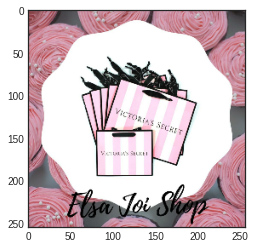

(256, 256, 3)


In [7]:
image, _ = next(iter(train_ds))
plt.imshow(image)
plt.show()
print(image.shape)

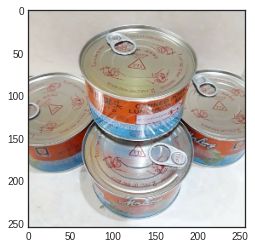

(256, 256, 3)


In [8]:
image, _ = next(iter(valid_ds))
plt.imshow(image)
plt.show()
print(image.shape)

In [9]:
train_ds = train_ds.batch(64).prefetch(buffer_size = tf.data.experimental.AUTOTUNE)
valid_ds = valid_ds.batch(64 * 2)

In [10]:
import tensorflow.keras.layers as L
import tensorflow.keras.models as M

def autoencoder(input_shape):
    inputs = L.Input(shape = input_shape)
    encoded = L.Conv2D(filters = 16, kernel_size = (3, 3), padding = "same", activation = "relu")(inputs)
    encoded = L.BatchNormalization()(encoded)
    encoded = L.MaxPooling2D(pool_size = (2, 2), padding = "same")(encoded)
    encoded = L.Conv2D(filters = 32, kernel_size = (3, 3), padding = "same", activation = "relu")(encoded)
    encoded = L.BatchNormalization()(encoded)
    encoded = L.MaxPooling2D(pool_size = (2, 2), padding = "same")(encoded)
    encoded = L.Conv2D(filters = 64, kernel_size = (3, 3), padding = "same", activation = "relu")(encoded)
    encoded = L.BatchNormalization()(encoded)
    encoded = L.MaxPooling2D(pool_size = (2, 2), padding = "same")(encoded)
    """
    encoded = L.Conv2D(filters = 64, kernel_size = (3, 3), padding = "same", activation = "relu")(encoded)
    encoded = L.BatchNormalization()(encoded)
    encoded = L.MaxPooling2D(pool_size = (2, 2), padding = "same")(encoded)
    encoded = L.Conv2D(filters = 64, kernel_size = (3, 3), padding = "same", activation = "relu")(encoded)
    encoded = L.BatchNormalization()(encoded)
    encoded = L.MaxPooling2D(pool_size = (2, 2), padding = "same")(encoded)
    encoded = L.Conv2D(filters = 128, kernel_size = (3, 3), padding = "same", activation = "relu")(encoded)
    encoded = L.BatchNormalization()(encoded)
    encoded = L.MaxPooling2D(pool_size = (2, 2), padding = "same")(encoded)
    """

#    features = encoded
    
    """
    decoded = L.Conv2D(filters = 128, kernel_size = (3, 3), padding = "same", activation = "relu")(encoded)
    decoded = L.UpSampling2D(size = (2, 2))(decoded)
    decoded = L.Conv2D(filters = 64, kernel_size = (3, 3), padding = "same", activation = "relu")(decoded)
    decoded = L.UpSampling2D(size = (2, 2))(decoded)
    decoded = L.Conv2D(filters = 64, kernel_size = (3, 3), padding = "same", activation = "relu")(decoded)
    decoded = L.UpSampling2D(size = (2, 2))(decoded)
    """
    decoded = L.Conv2D(filters = 64, kernel_size = (3, 3), padding = "same", activation = "relu")(encoded)
    decoded = L.UpSampling2D(size = (2, 2))(decoded)
    decoded = L.Conv2D(filters = 32, kernel_size = (3, 3), padding = "same", activation = "relu")(decoded)
    decoded = L.UpSampling2D(size = (2, 2))(decoded)
    decoded = L.Conv2D(filters = 16, kernel_size = (3, 3), padding = "same", activation = "relu")(decoded)
    decoded = L.UpSampling2D(size = (2, 2))(decoded)
    decoded = L.Conv2D(filters = 3, kernel_size = (3, 3), padding = "same", activation = "sigmoid")(decoded)
    
    encoder = M.Model(inputs = inputs, outputs = encoded)
    autoencoder = M.Model(inputs = inputs, outputs = decoded)
    autoencoder.compile(optimizer = "Adam", loss = "binary_crossentropy")
    return autoencoder, encoder

tf.keras.backend.clear_session()
autoencoder, encoder = autoencoder((256, 256, 3))
autoencoder.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 256, 256, 3)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 256, 256, 16)      448       
_________________________________________________________________
batch_normalization (BatchNo (None, 256, 256, 16)      64        
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 128, 128, 16)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 128, 128, 32)      4640      
_________________________________________________________________
batch_normalization_1 (Batch (None, 128, 128, 32)      128       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 64, 64, 32)        0   

In [11]:
TRAINING = False

if TRAINING:
    history = autoencoder.fit(
        train_ds, validation_data = valid_ds, epochs = 1,
        callbacks = [
            tf.keras.callbacks.EarlyStopping(monitor = "val_loss", patience = 3, mode = "min"),
            tf.keras.callbacks.ModelCheckpoint(filepath = "autoencoder.h5", monitor = "val_loss", mode = "min", save_best_only = True, save_weights_only = True)
        ]
    )
else:
    autoencoder.load_weights("../input/shoppee-autoencoder0324/autoencoder.h5")

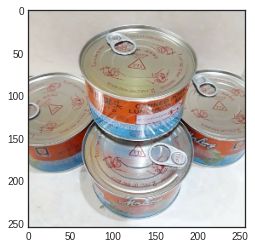

In [12]:
image = next(iter(valid_ds))[0][0]
plt.imshow(image)
plt.show()

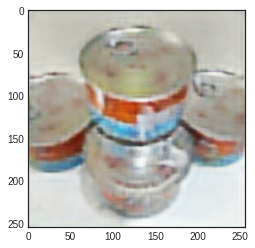

In [13]:
plt.imshow(autoencoder.predict(next(iter(valid_ds))[0])[0])
plt.show()

In [14]:
from tqdm.notebook import tqdm, trange
from sklearn.neighbors import NearestNeighbors
import gc

# INFERENCE

In [15]:
CV = True

test = pd.read_csv("../input/shopee-product-matching/test.csv")
if test.shape[0] > 3:
    CV = False

if CV:
    test = valid.copy()
    DIR = "../input/shopee-product-matching/train_images"
else:
    DIR = "../input/shopee-product-matching/test_images"
print(test.shape, DIR)

(6850, 5) ../input/shopee-product-matching/train_images


In [16]:
CHUNK = 1024
CHUNK_SIZE = test.shape[0] // CHUNK
if test.shape[0] % CHUNK != 0:
    CHUNK_SIZE += 1

In [17]:
def test_preprocess(path):
    path = DIR + "/" + path
    image = tf.io.read_file(path)
    image = tf.image.decode_jpeg(image, channels = 3)
    image = tf.image.resize(image, [256, 256])
    image = tf.cast(image, tf.float32) / 255.0
    return image

test["image_preds"] = ""
KNN = 50
knn = NearestNeighbors(n_neighbors = KNN)

for chunk in range(CHUNK_SIZE):
    a = chunk * CHUNK
    b = min((chunk + 1) * CHUNK, test.shape[0])
    
    test_ds = tf.data.Dataset.from_tensor_slices((test.iloc[a : b]["image"].values))
    test_ds = test_ds.map(test_preprocess)
    test_ds = test_ds.batch(64 * 2)

    test_encoded = []
    for image in tqdm(test_ds):
        batch_size = image.shape[0]
        encoded = encoder.predict(image)
        test_encoded.append(encoded.reshape(batch_size, -1))
    test_encoded = np.concatenate(test_encoded, axis = 0)
    
    knn.fit(test_encoded)
    distances, indices = knn.kneighbors(test_encoded)
    del test_encoded; gc.collect()

    preds = []
    for i in range(b - a):
        idx = np.where(distances[i] < 5.0)[0]
        ids = indices[i, idx]
        preds.append(test.iloc[a: b].iloc[ids]["posting_id"].values)

    del distances, indices; gc.collect()
    test.iloc[a : b,]["image_preds"] = preds
test.head()

  0%|          | 0/8 [00:00<?, ?it/s]

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

,posting_id,image,image_phash,title,label_group,image_preds
2,train_2288590299,000a190fdd715a2a36faed16e2c65df7.jpg,b94cb00ed3e50f78,Maling TTS Canned Pork Luncheon Meat 397 gr,2395904891,[train_2288590299]
5,train_2464356923,0013e7355ffc5ff8fb1ccad3e42d92fe.jpg,bbd097a7870f4a50,CELANA WANITA (BB 45-84 KG)Harem wanita (bisa...,2660605217,[train_2464356923]
13,train_998568945,001f4c8331d0554d133b10d85b7fafb2.jpg,d8a6082bb93d2db5,Lampu led t5 Speedometer Dashboard Motor Mobil...,4206465630,[train_998568945]
21,train_2238403912,003524b70715bf6bfa00451ca08e66e0.jpg,ba35c44a3fb7c068,Kangaroo Teflon / Allu Fry Pan 18 cm - KG652,531768918,[train_2238403912]
23,train_1180155871,00369839c7d94411e54437b7cf59b603.jpg,bbc1c43ec3633ec0,[INCLUDE PAJAK] NCT DREAM RELOAD ALBUM,2224428568,[train_1180155871]


In [18]:
test["matches"] = test.apply(lambda x: " ".join(np.unique(x["image_preds"])) , axis = 1)
submit = test[["posting_id", "matches"]].copy()
submit.to_csv("submission.csv", index = False)
submit

,posting_id,matches
2,train_2288590299,train_2288590299
5,train_2464356923,train_2464356923
13,train_998568945,train_998568945
21,train_2238403912,train_2238403912
23,train_1180155871,train_1180155871
...,...,...
34236,train_2287008377,train_2287008377
34240,train_1896175606,train_1896175606
34241,train_119714892,train_119714892
34246,train_769054909,train_769054909
